<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [ ]:
# Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Reading Data

In [ ]:
if os.path.isfile('/content/drive/MyDrive/Case Studies/Facebook/data/after_eda/train_pos_after_eda.csv'):
# reading only +ve train data 
    train_graph = nx.read_edgelist('/content/drive/MyDrive/Case Studies/Facebook/data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
else:
    print("please run the FB_EDA.ipynb or download the files from drive")

DiGraph with 1780722 nodes and 7550015 edges


# 2. Similarity measures

whenever we are given a graph based problem Featurization is the most important task.



## 2.1 Jaccard Distance:
http://www.statisticshowto.com/jaccard-index/



\begin{equation}
j = \frac{|X\cap Y|}{|X \cup Y|} 
\end{equation}

https://networkx.org/documentation/stable/reference/classes/generated/networkx.DiGraph.successors.html

In [ ]:
# for followees, It includes all the users that vertex U and vertex V are following.

def jaccard_for_followees(a,b): # a and b are two nodes.

    try:# Raises an error if any of the node is not in graph.

        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
        # if any of the sets is Empty return 0
            return 0
    
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
              (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
    # return 0 if there is no path between two users.
        return 0

    return sim # return the calculated similarity

https://www.vedantu.com/maths/what-are-the-successor-and-predecessor

In [ ]:
# one test case
print(jaccard_for_followees(273084,1505602))

0.0


In [ ]:
# node 1635354 is not in graph 
print(jaccard_for_followees(273084,1505602))

0.0


In [ ]:
# for followers, same explanation just followe set instead of followees 

def jaccard_for_followers(a,b):

    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
  
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [ ]:
print(jaccard_for_followers(273084,470294))

0


In [ ]:
#node 1635354 not in graph 
print(jaccard_for_followers(669354,1635354))

0


## 2.2 Cosine distance (Otsuka - Ochiai coefficient).




It is used when a and b are sets.

It is different from standard cosine distance.

https://en.wikipedia.org/wiki/Cosine_similarity




\begin{equation}
Cosine Distance = \frac{|X\cap Y|}{(|X|\cdot|Y|)} 
\end{equation}


\begin{equation}
Otsuka-Ochiai - coefficient = \frac{|X\cap Y|}{sqrt(|X|\cdot|Y|)} 
\end{equation}

In [ ]:
#for followees

def cosine_for_followees(a,b):
    try:
    # try if path exists then check for the number of successors .    
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        # if any of the sets is empty return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

In [ ]:
print(cosine_for_followees(273084,1505602))

0.0


In [ ]:
print(cosine_for_followees(273084,1635354))

0


In [ ]:
def cosine_for_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [ ]:
print(cosine_for_followers(2,470294))

0.02886751345948129


In [ ]:
print(cosine_for_followers(669354,1635354))

0


## 3. Ranking Measures

https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html

PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links.

https://en.wikipedia.org/wiki/File:PageRanks-Example.jpg

Mathematical PageRanks for a simple network, expressed as percentages. (Google uses a logarithmic scale.) Page C has a higher PageRank than Page E, even though there are fewer links to C; the one link to C comes from an important page and hence is of high value. If web surfers who start on a random page have an 85% likelihood of choosing a random link from the page they are currently visiting, and a 15% likelihood of jumping to a page chosen at random from the entire web, they will reach Page E 8.1% of the time. <b>(The 15% likelihood of jumping to an arbitrary page corresponds to a damping factor of 85%.) Without damping, all web surfers would eventually end up on Pages A, B, or C, and all other pages would have PageRank zero. In the presence of damping, Page A effectively links to all pages in the web, even though it has no outgoing links of its own.</b>

## 3.1 Page Ranking

https://en.wikipedia.org/wiki/PageRank


In [ ]:
%%time 
# Wall time: 55.4 s
if not os.path.isfile('/content/drive/MyDrive/Case Studies/Facebook/data/fea_sample/page_rank.p'):

  pr = nx.pagerank(train_graph,alpha = 0.85) # alpha is hyperparameter.
  pickle.dump(pr,open('/content/drive/MyDrive/Case Studies/Facebook/data/fea_sample/page_rank.p','wb'))

else:
  pr = pickle.load( open('/content/drive/MyDrive/Case Studies/Facebook/data/fea_sample/page_rank.p','rb'))

CPU times: user 523 ms, sys: 159 ms, total: 683 ms
Wall time: 1.13 s


In [ ]:
print(type(pr) ) # it has nodes with probabilty that a random user would land on the particular page.


print('min',pr[min(pr,key = pr.get)]) 
print('max',pr[max(pr,key = pr.get)])  


<class 'dict'>
min 1.6556497245737814e-07
max 2.7098251341935827e-05


In [ ]:
mean_pr = float(sum( pr.values()) ) /len(pr)
print("mean ",mean_pr)
 # useful in imputing beacause there are some nodes that are not present in our test dataset

mean  5.615699699389075e-07


# 4. Other Graph Features

## 4.1 Shortest path:

Getting Shortest path between two nodes, if nodes have direct path i.e directly connected then we are removing that edge and calculating path. 
because if shortest path length is one then that means user a already follow user b or vice versa.

In [ ]:
# if has direct edge then deleting that edge and calculating shortest path

def compute_shortest_path_length(a,b):
    p = -1
    try:
        if train_graph.has_edge(a,b): 
        # if there is a direct edge between a and b

            train_graph.remove_edge(a,b)

            p = nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b) # adding the edge back after calculating the shortest path.
       
        else:
        # if there is not any direct edge from a to b
            p = nx.shortest_path_length(train_graph,source=a,target=b)
        return p 

    except: # will execute if any of  a and b are not present in the graph.
        return -1

In [ ]:
# testing
compute_shortest_path_length(77697, 826021)

10

In [ ]:
# testing
compute_shortest_path_length(669354,1635354)

-1

## 4.2 Checking for same community

WCC can be thought of as community of people who shares something similar among themselves. e.g college friends, work related friends. Thus if two users who are in same community have very high chance of following each other.

Thus WCC helps us detect communities in the graph.

https://networkx.guide/algorithms/components/weakly-connected-components/

DiGraph with 6 nodes and 4 edges


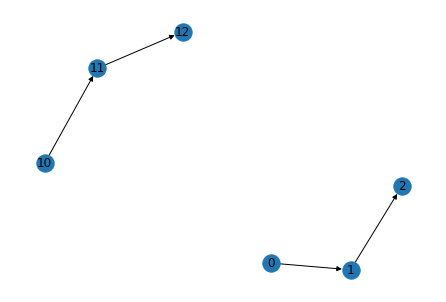

In [ ]:
G = nx.path_graph(3, create_using =nx.DiGraph()) # Return the Path graph P_n of n nodes linearly connected by n-1 edges.
nx.add_path(G, [10, 11, 12])

print(nx.info(G))
nx.draw(G, with_labels=True)
plt.show()

In [ ]:
print(type (nx.weakly_connected_components(G)))
print(list (nx.weakly_connected_components(G)))

<class 'generator'>
[{0, 1, 2}, {10, 11, 12}]


In [ ]:
%%time

# getting weekly connected edges from graph. 

wcc = list(nx.weakly_connected_components(train_graph)) # storing all the WCC in a list.


def belongs_to_same_wcc(a,b):
    index = []
   
    if train_graph.has_edge(b,a): 
        return 1
   
    if train_graph.has_edge(a,b): # if there is an edge from a to b , but not from b to a.
   
            for i in wcc:  # iterate over all the wcc.
                if a in i: # if a is found in any wcc.
                    index = i 
                    break
   
            if (b in index): 
            # if b is also in same wcc as that of a.
                train_graph.remove_edge(a,b) 
                
                if compute_shortest_path_length(a,b) == -1: 
                # if there is no way to reach b from a after removing direct edge from a to b then return 0.
                    train_graph.add_edge(a,b) 
                # add back the removed direct edge.
                    return 0 
   
                else: # if path exist then return 1
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0

    else: 
    # if no direct edge from a to b  and no direct edge from b to a.
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index): 
            # if b is in same wcc as that of a return 1
                return 1
            else:
                return 0

CPU times: user 18.3 s, sys: 201 ms, total: 18.5 s
Wall time: 18.6 s


In [ ]:
belongs_to_same_wcc(861, 1659750) # checking if user 862 belongs to the same community as that of 1659750

0

In [ ]:
belongs_to_same_wcc(669354,1635354)

0

## 4.3 Adamic/Adar Index:

To predict links in social network



Adamic/Adar measures is defined as inverted sum of degrees of common 
neighbours(any vertex connected directly to the vertex x is neighbor of vertex x) for given two vertices.
$$A(x,y)=\sum_{u \in N(x) \cap N(y)}\frac{1}{log(|N(u)|)}$$

https://en.wikipedia.org/wiki/Adamic/Adar_index

In [ ]:
# adar index
# first find the common neighbors and store them in list say 'n' 
# now every vertex in list n will have it's own neighborhood,let's say any vertex
# u from list n, if u has very large neighborhood then chances that u is celebrity are very high.
# thus now if x and y are following u or somehow they are connected to u 
# like it is also possible that u is following either or both of them

# the chances that x and y will follow each other are very low. if i am following eminem and
# someone else is also following him does not mean 
# that i will follow eminem's followers.however if u is small then chances of x following y are very high.

def calc_adar_in(a,b):
    sum = 0
    try:
        n = list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))

        if len(n)!=0:
        
            for i in n:
                
                followers = list( train_graph.predecessors(i) ) # followers of shared vertices x and y.
                sum = sum + ( 1/np.log10(len(followers)) )
                
            return sum
        
        else:
            return 0
    except:
        return 0

In [ ]:
calc_adar_in(1,189226)

0

In [ ]:
calc_adar_in(669354,1635354)

0

## 4.4 Is persion was following back:

In [ ]:
def follows_back(a,b): # actually we are asking if there exist a node from a to b. thus this function is checking 
    if train_graph.has_edge(b,a): # if there is an edge from b to a or not bcz if there is an edge from b to a then there is very high chance
        return 1                  # of having an edge from a to b also.
    else:
        return 0

In [ ]:
follows_back(1,189226)

1

In [ ]:
follows_back(669354,1635354)

0

## 4.5 Katz Centrality:

It is used to measure the influence of the node.

The influence of node a depends on the influence of it's neighbors and neighbors influence depends on their neighbors, It is very similar to google's page rank algorithm.

https://en.wikipedia.org/wiki/Katz_centrality

https://www.geeksforgeeks.org/katz-centrality-centrality-measure/
 Katz centrality computes the centrality for a node 
    based on the centrality of its neighbors. It is a 
    generalization of the eigenvector centrality. The
    Katz centrality for node `i` is
 
$$x_i = \alpha \sum_{j} A_{ij} x_j + \beta,$$
where `A` is the adjacency matrix of the graph G 
with eigenvalues $$\lambda$$.

The parameter $$\beta$$ controls the initial centrality and 

$$\alpha < \frac{1}{\lambda_{max}}.$$

* This is alternative of Page Rank

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/Case Studies/Facebook/data/fea_sample/katz.p'):
    katz = nx.katz.katz_centrality(train_graph,alpha = 0.005,beta = 1)
    pickle.dump(katz,open('/content/drive/MyDrive/Case Studies/Facebook/data/fea_sample/katz.p','wb'))
else:
    katz = pickle.load(open('/content/drive/MyDrive/Case Studies/Facebook/data/fea_sample/katz.p','rb'))

In [ ]:
print(type(katz))

print('min',katz[min(katz, key = katz.get)])
print('max',katz[max(katz, key = katz.get)])

<class 'dict'>
min 0.0007313532484065916
max 0.003394554981699122


In [ ]:
mean_katz = float(sum(katz.values())) / len(katz) # mean is useful in imputations.
print(mean_katz)

0.0007483800935562018


## 4.6 Hits Score
The HITS algorithm computes two numbers for a node. Authorities estimates the node value based on the incoming links. Hubs estimates the node value based on outgoing links.Thus if outdegree is large then the page is called Hub.

https://en.wikipedia.org/wiki/HITS_algorithm

if there is a node with lot's of incoming edges(Authority) then that node is a celebrity.

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/Case Studies/Facebook/data/fea_sample/hits.p'):
    
    hits = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
    
    pickle.dump(hits,open('/content/drive/MyDrive/Case Studies/Facebook/data/fea_sample/hits.p','wb'))
else:
    hits = pickle.load(open('/content/drive/MyDrive/Case Studies/Facebook/data/fea_sample/hits.p','rb'))

In [ ]:
G = nx.path_graph(4)
h, a = nx.hits(G) 
# Returns :- (hubs,authorities) two-tuple of dictionaries Two dictionaries keyed by node containing the hub and authority values.
print(h)
print(a)
print("\n")

print('min',min(h.values()))
print('max',max(h.values()))

{0: 0.7144179817785157, 1: -0.5379185879418464, 2: 1.1559525766917413, 3: -0.3324519705284104}
{0: -0.3324519705284105, 1: 1.1559525766917416, 2: -0.5379185879418464, 3: 0.7144179817785156}


min -0.5379185879418464
max 1.1559525766917413


In [ ]:
print(type(hits))
print(len(hits) )

print('min',hits[0][min(hits[0], key = hits[0].get)])
print('max',hits[0][max(hits[0], key = hits[0].get)])

print('mean',float(sum(hits[0].values())) / len(hits[0]))

<class 'tuple'>
2
min 0.0
max 0.004868653378780953
mean 5.615699699344123e-07


# 5. Featurization

## 5. 1 Reading a sample of Data from both train and test

In [ ]:
# ! gdown --id 1lcxzVZ0-MkPmoH3lS35Q8rRfrecKSXb1
# ! gdown --id 1_KN7S8zfHdrkRjRYOEtBxBVq8JrGxPXD

In [ ]:
import random
if os.path.isfile('/content/drive/MyDrive/data/after_eda/train_after_eda.csv'):
    filename = "/content/drive/MyDrive/data/after_eda/train_after_eda.csv"
    # you uncomment this line, if you dont know the length of the file name
    # here we have hardcoded the number of lines as 15100030
    # n_train = sum(1 for line in open(filename)) # number of records in file (excludes header).
    n_train =  15100028
    s = 100000 #desired sample size
    skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))
    # print(n_train)
    # https://stackoverflow.com/a/22259008/4084039

In [ ]:
if os.path.isfile('/content/drive/MyDrive/data/after_eda/test_after_eda.csv'):
    filename = "/content/drive/MyDrive/data/after_eda/test_after_eda.csv"
    # you uncomment this line, if you dont know the length of the file name
    # here we have hardcoded the number of lines as 3775008
    # n_test = sum(1 for line in open(filename)) # number of records in file (excludes header)
    n_test = 3775006
    s = 50000 #desired sample size
    skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))
    # print(n_test)
    #https://stackoverflow.com/a/22259008/4084039

In [ ]:
print("Number of rows in the train data file:", n_train)
print("Number of rows we are going to elimiate in train data are",len(skip_train))
print("Number of rows in the test data file:", n_test)
print("Number of rows we are going to elimiate in test data are",len(skip_test))

Number of rows in the train data file: 15100028
Number of rows we are going to elimiate in train data are 15000028
Number of rows in the test data file: 3775006
Number of rows we are going to elimiate in test data are 3725006


In [ ]:
#https://drive.google.com/file/d/19mviN_yeJIfakb4kU5NfKdQlOQtaQ-kH/view?usp=sharing
# !gdown --id 19mviN_yeJIfakb4kU5NfKdQlOQtaQ-kH 

In [ ]:
#https://drive.google.com/file/d/1H6qybuXr8i_USWu3k3ulXEOurc-SElUh/view?usp=sharing
# !gdown --id 1H6qybuXr8i_USWu3k3ulXEOurc-SElUh

In [ ]:
df_final_train = pd.read_csv('/content/drive/MyDrive/data/after_eda/train_after_eda.csv', skiprows = skip_train, names=['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv('/content/drive/MyDrive/data/train_y.csv', skiprows=skip_train, names=['indicator_link'])

print("Our train matrix size ",df_final_train.shape)
df_final_train.head(3)

Our train matrix size  (100002, 3)


,source_node,destination_node,indicator_link
0,273084,1505602,1
1,443328,1193183,1
2,707628,681447,1


In [ ]:
df_final_test = pd.read_csv('/content/drive/MyDrive/data/after_eda/test_after_eda.csv', skiprows=skip_train, names=['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv('/content/drive/MyDrive/data/test_y.csv', skiprows=skip_train, names=['indicator_link'])

print("Our test matrix size ",df_final_test.shape)
df_final_test.tail(3)

Our test matrix size  (25022, 3)


,source_node,destination_node,indicator_link
25019,749937,399140,0
25020,724354,620267,0
25021,982876,112683,0


## 5.2 Adding a set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>jaccard_followers</li>
<li>jaccard_followees</li>
<li>cosine_followers</li>
<li>cosine_followees</li>
<li>num_followers_s</li>
<li>num_followees_s</li>
<li>num_followers_d</li>
<li>num_followees_d</li>
<li>inter_followers</li>
<li>inter_followees</li>
</ol>

In [ ]:
def compute_features_stage1(df_final):
    # calculating no of followers followees for source and destination.
    # calculating intersection of followers and followees for source and destination.
    
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    
    for i,row in df_final.iterrows():
        try:
            s1 = set(train_graph.predecessors(row['source_node']))
            s2 = set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return  num_followers_s,num_followees_s,num_followers_d,num_followees_d,inter_followers,inter_followees

In [ ]:
if True: # num_followers_d was missing from the "storage_sample_stage1.h5" file so we have to run this whole cell.

    df_final_train['num_followers_s'], df_final_train['num_followers_d'], \
    df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
    df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)
    
    df_final_test['num_followers_s'], df_final_test['num_followers_d'], \
    df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
    df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)
    
    # hdf = HDFStore('/content/drive/MyDrive/data/fea_sample/storage_sample_stage1.h5')
    # hdf.put('train_df',df_final_train, format='table', data_columns=True)
    # hdf.put('test_df', df_final_test,  format='table', data_columns=True)
    # hdf.close()
else:
    df_final_train = read_hdf('/content/drive/MyDrive/data/fea_sample/storage_sample_stage1.h5', 'train_df',mode='r')
    df_final_test = read_hdf('/content/drive/MyDrive/data/fea_sample/storage_sample_stage1.h5',  'test_df',mode='r')

In [ ]:
df_final_train.head()


,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,num_followers_d
0,273084,1505602,1,0,0.000000,0.000000,0.000000,11,6,8,0,0,0.000000,0,1,4,0.377964,0.250000,0.627964,0.094491,1.005929,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226339e-16,2.231877e-15,15
1,832016,1543415,1,0,0.187135,0.028382,0.343828,17,94,142,11,32,16.362912,0,1,2,0.102598,0.127000,0.229598,0.013030,0.332196,0.356598,2.353458e-07,6.427660e-07,0.000845,0.001317,3.906648e-11,9.424102e-11,1.208074e-11,1.273080e-10,61
2,1325247,760242,1,0,0.369565,0.156957,0.566038,35,28,22,26,17,10.991826,0,1,2,0.185695,0.154303,0.339999,0.028653,0.525694,0.494302,6.211019e-07,5.179801e-07,0.000885,0.000855,7.730764e-114,4.067322e-114,2.681298e-113,2.199205e-113,41
3,1368400,1006992,1,0,0.000000,0.000000,0.000000,2,11,7,0,0,0.000000,0,1,6,0.288675,0.408248,0.696923,0.117851,0.985599,1.105172,2.998153e-07,1.704245e-06,0.000739,0.000773,5.443738e-17,4.139999e-16,2.413250e-14,6.688064e-15,5
4,140165,1708748,1,0,0.000000,0.000000,0.000000,5,1,3,0,0,0.000000,0,0,-1,1.000000,0.301511,1.301511,0.301511,2.301511,1.603023,4.349180e-07,2.089590e-07,0.000751,0.000735,3.887821e-16,4.721269e-16,7.552255e-16,2.734009e-18,11


In [ ]:
df_final_test.head() # num_followers_d column is missing.but they have added it later check after couple of cells.

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,num_followers_d
0,848424,784690,1,0,0.0,0.029161,0.000000,6,14,9,1,0,0.000000,1,1,2,0.258199,0.377964,0.636163,0.097590,0.894362,1.014128,6.557971e-07,0.000002,0.000754,0.000786,3.243237e-16,1.745627e-16,2.969838e-15,9.269213e-14,6
1,483294,1255532,1,0,0.0,0.000000,0.000000,2,17,19,0,0,0.000000,1,1,7,0.235702,0.707107,0.942809,0.166667,1.178511,1.649916,2.172064e-07,0.000001,0.000739,0.000801,1.702625e-19,2.706300e-15,2.522357e-16,5.277458e-15,1
2,626190,1729265,1,0,0.0,0.000000,0.000000,15,10,9,0,0,0.000000,0,1,5,0.301511,0.242536,0.544047,0.073127,0.845558,0.786583,1.853369e-06,0.000002,0.000789,0.000770,9.426796e-14,4.116616e-16,2.253244e-15,2.079387e-15,16
3,947219,425228,1,0,0.0,0.000000,0.000000,11,37,34,0,0,0.000000,0,1,3,0.162221,0.301511,0.463733,0.048912,0.625954,0.765244,7.000791e-07,0.000002,0.000778,0.000884,9.876114e-14,1.039593e-13,1.511694e-14,3.478438e-14,10
4,991374,975044,1,0,0.2,0.042767,0.347833,12,27,27,4,7,6.136433,0,1,2,0.188982,0.250000,0.438982,0.047246,0.627964,0.688982,7.103008e-07,0.000001,0.000779,0.000840,1.557332e-15,1.096037e-14,5.180869e-15,1.296135e-14,15


In [ ]:
# a = df_final_train['num_followers_s'].values
# b = df_final_train['num_followers_d'].values

# for x,y in (zip(a,b)):
  # if x == 0:
    # if y != 0:
      # print('i')


In [ ]:
# print (df_final_train['num_followers_s'].values)
# print(a)

In [ ]:
# print(a)
# np.count_nonzero(a)

In [ ]:
# np.count_nonzero(b)

In [ ]:
# ! gdown --id 1fDJptlCFEWNV5UNGPc4geTykgFI3PDCV

In [ ]:
# df_final_train = read_hdf('/content/drive/MyDrive/data/fea_sample/storage_sample_stage4.h5',mode='r')
# df_final_test  = read_hdf('/content/drive/MyDrive/data/fea_sample/storage_sample_stage4.h5',mode='r')

In [ ]:
df_final_train.tail()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,num_followers_d
99997,139353,893843,0,0,0.0,0.0,0.0,0,7,10,0,0,0.0,0,0,-1,0.353553,0.707107,1.060660,0.250000,1.414214,1.767767,1.655650e-07,7.746044e-07,0.000731,0.000763,0.000000e+00,2.622256e-15,0.000000e+00,3.937186e-15,1
99998,910842,704068,0,0,0.0,0.0,0.0,2,0,1,0,0,0.0,0,1,-1,1.000000,0.447214,1.447214,0.447214,2.447214,1.894427,2.619498e-07,1.655650e-07,0.000739,0.000731,2.985245e-19,4.209193e-25,2.937528e-19,0.000000e+00,4
99999,794228,1172755,0,0,0.0,0.0,0.0,3,0,1,0,0,0.0,0,1,-1,1.000000,0.408248,1.408248,0.408248,2.408248,1.816497,3.360416e-07,1.655650e-07,0.000743,0.000731,1.300126e-15,1.067222e-18,1.874225e-15,0.000000e+00,5
100000,949992,1854931,0,0,0.0,0.0,0.0,1,1,0,0,0,0.0,0,1,10,0.707107,0.577350,1.284457,0.408248,1.991564,1.861807,2.848986e-07,3.246765e-07,0.000735,0.000735,1.003286e-17,0.000000e+00,1.428238e-17,1.871381e-21,2
100001,1642037,1090977,0,0,0.0,0.0,0.0,16,1,0,0,0,0.0,0,1,8,0.707107,0.258199,0.965306,0.182574,1.672412,1.223505,3.317631e-06,1.697892e-07,0.000792,0.000735,2.654093e-16,0.000000e+00,3.962767e-15,1.504913e-15,14


In [ ]:
# df_final_train_new = df_final_train.drop(['num_followers_s',	'num_followees_s',	'num_followees_d'	,'inter_followers',	'inter_followees'],axis=1) # don't take all of these columns.

In [ ]:
# df_final_train_new.head()

In [ ]:
# len(df_final_train)

In [ ]:
# df_final_train['num_followers_d']= compute_features_stage1(df_final_train) 

In [ ]:
# df_final_train.tail()

In [ ]:
# for val in df_final_train_new['num_followers_s'].values:
  # if(val>0):
    # print(val)

In [ ]:
# https://drive.google.com/file/d/10qJ04GRcaDxc16gmJXb8rpGPmlyys7E2/view?usp=sharing
# ! gdown --id 10qJ04GRcaDxc16gmJXb8rpGPmlyys7E2


## 5.3 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>adar index</li>
<li>is following back</li>
<li>belongs to same weakly connect components</li>
<li>shortest path between source and destination</li>
</ol>

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/data/fea_sample/storage_sample_stage2.h5'):

    # mapping adar index on train
    df_final_train['adar_index'] = df_final_train.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)
    
    # mapping adar index on test
    df_final_test['adar_index'] = df_final_test.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    
    # mapping followback or not on train
    df_final_train['follows_back'] = df_final_train.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    # mapping followback or not on test
    df_final_test['follows_back'] = df_final_test.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    
    # mapping same component of wcc or not on train
    df_final_train['same_comp'] = df_final_train.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

    # mapping same component of wcc or not on train
    df_final_test['same_comp'] = df_final_test.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)
    
    #--------------------------------------------------------------------------------------------------------
    
    # mapping shortest path on train 
    df_final_train['shortest_path'] = df_final_train.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
    
    # mapping shortest path on test
    df_final_test['shortest_path'] = df_final_test.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)

    hdf = HDFStore('data/fea_sample/storage_sample_stage2.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('/content/drive/MyDrive/data/fea_sample/storage_sample_stage2.h5', 'train_df',mode='r')
    df_final_test = read_hdf('/content/drive/MyDrive/data/fea_sample/storage_sample_stage2.h5', 'test_df',mode='r')

In [ ]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,num_followers_d
0,273084,1505602,1,0,0.000000,0.000000,0.000000,11,6,8,0,0,0.000000,0,1,4,0.377964,0.250000,0.627964,0.094491,1.005929,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226339e-16,2.231877e-15,15
1,832016,1543415,1,0,0.187135,0.028382,0.343828,17,94,142,11,32,16.362912,0,1,2,0.102598,0.127000,0.229598,0.013030,0.332196,0.356598,2.353458e-07,6.427660e-07,0.000845,0.001317,3.906648e-11,9.424102e-11,1.208074e-11,1.273080e-10,61
2,1325247,760242,1,0,0.369565,0.156957,0.566038,35,28,22,26,17,10.991826,0,1,2,0.185695,0.154303,0.339999,0.028653,0.525694,0.494302,6.211019e-07,5.179801e-07,0.000885,0.000855,7.730764e-114,4.067322e-114,2.681298e-113,2.199205e-113,41
3,1368400,1006992,1,0,0.000000,0.000000,0.000000,2,11,7,0,0,0.000000,0,1,6,0.288675,0.408248,0.696923,0.117851,0.985599,1.105172,2.998153e-07,1.704245e-06,0.000739,0.000773,5.443738e-17,4.139999e-16,2.413250e-14,6.688064e-15,5
4,140165,1708748,1,0,0.000000,0.000000,0.000000,5,1,3,0,0,0.000000,0,0,-1,1.000000,0.301511,1.301511,0.301511,2.301511,1.603023,4.349180e-07,2.089590e-07,0.000751,0.000735,3.887821e-16,4.721269e-16,7.552255e-16,2.734009e-18,11


## 5.4 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>Weight Features
    <ul>
        <li>weight of incoming edges</li>
        <li>weight of outgoing edges</li>
        <li>weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges * weight of outgoing edges</li>
        <li>2*weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges + 2*weight of outgoing edges</li>
    </ul>
</li>
<li>Page Ranking of source</li>
<li>Page Ranking of dest</li>
<li>katz of source</li>
<li>katz of dest</li>
<li>hubs of source</li>
<li>hubs of dest</li>
<li>authorities_s of source</li>
<li>authorities_s of dest</li>
</ol>

#### Weight Features

In order to determine the similarity of nodes, an edge weight value was calculated between nodes. Edge weight decreases as the neighbor count goes up. Intuitively, consider one million people following a celebrity on a social network then chances are most of them never met each other or the celebrity. On the other hand, if a user has 30 contacts in his/her social network, the chances are higher that many of them know each other. 
`credit` - Graph-based Features for Supervised Link Prediction
William Cukierski, Benjamin Hamner, Bo Yang

\begin{equation}
W = \frac{1}{\sqrt{1+|X|}}
\end{equation}

it is directed graph so calculated Weighted in and Weighted out differently

In [ ]:
# weight for source and destination of each link

Weight_in = {}
Weight_out = {}

for i in  tqdm(train_graph.nodes()):

    s1 = set(train_graph.predecessors(i)) # number of followers
    w_in = 1.0/(np.sqrt(1+len(s1)))
    Weight_in[i] = w_in
    
    s2=set(train_graph.successors(i)) # number of following
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_out[i]=w_out
    
# for imputing with mean

mean_weight_in  = np.mean(list(Weight_in.values()))
print(mean_weight_in)

mean_weight_out = np.mean(list(Weight_out.values()))
print(mean_weight_out)

100%|██████████| 1780722/1780722 [00:19<00:00, 92428.12it/s] 


0.5882385057963813
0.6014569175347213


In [ ]:
if not os.path.isfile('/content/drive/MyDrive/data/fea_sample/storage_sample_stage3.h5'):
    
    # mapping to pandas train
    df_final_train['weight_in']  = df_final_train.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_train['weight_out'] = df_final_train.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out)) 

    # mapping to pandas test
    df_final_test['weight_in'] = df_final_test.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in)) # if x is not present then
    df_final_test['weight_out'] = df_final_test.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))# mean_weight_in will get selected.


    # some features engineerings on the in and out weights
    df_final_train['weight_f1'] = df_final_train.weight_in + df_final_train.weight_out
    df_final_train['weight_f2'] = df_final_train.weight_in * df_final_train.weight_out
    df_final_train['weight_f3'] = (2*df_final_train.weight_in + 1*df_final_train.weight_out)
    df_final_train['weight_f4'] = (1*df_final_train.weight_in + 2*df_final_train.weight_out)

    # some features engineerings on the in and out weights
    df_final_test['weight_f1'] = df_final_test.weight_in + df_final_test.weight_out
    df_final_test['weight_f2'] = df_final_test.weight_in * df_final_test.weight_out
    df_final_test['weight_f3'] = (2*df_final_test.weight_in + 1*df_final_test.weight_out)
    df_final_test['weight_f4'] = (1*df_final_test.weight_in + 2*df_final_test.weight_out)

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/data/fea_sample/storage_sample_stage3.h5'):
    
    # page rank for source and destination in Train and Test
    # if anything not there in train graph then adding mean page rank.

    df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda x: pr.get(x,mean_pr))
    df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda x: pr.get(x,mean_pr))

    df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda x: pr.get(x,mean_pr))
    df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda x: pr.get(x,mean_pr))
    
    #================================================================================

    # Katz centrality score for source and destination in Train and test
    # if anything not there in train graph then adding mean katz score
    
    df_final_train['katz_s'] = df_final_train.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda x: katz.get(x,mean_katz))

    df_final_test['katz_s'] = df_final_test.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda x: katz.get(x,mean_katz))
    
    #================================================================================

    # Hits algorithm score for source and destination in Train and test
    # if anything not there in train graph then adding 0

    df_final_train['hubs_s'] = df_final_train.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_train['hubs_d'] = df_final_train.destination_node.apply(lambda x: hits[0].get(x,0))

    df_final_test['hubs_s'] = df_final_test.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_test['hubs_d'] = df_final_test.destination_node.apply(lambda x: hits[0].get(x,0))
    
    #================================================================================

    # Hits algorithm score for source and destination in Train and Test
    # if anything not there in train graph then adding 0
    
    df_final_train['authorities_s'] = df_final_train.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_train['authorities_d'] = df_final_train.destination_node.apply(lambda x: hits[1].get(x,0))

    df_final_test['authorities_s'] = df_final_test.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_test['authorities_d'] = df_final_test.destination_node.apply(lambda x: hits[1].get(x,0))
    #================================================================================

    hdf = HDFStore('data/fea_sample/storage_sample_stage3.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('/content/drive/MyDrive/data/fea_sample/storage_sample_stage3.h5', 'train_df',mode='r')
    df_final_test = read_hdf('/content/drive/MyDrive/data/fea_sample/storage_sample_stage3.h5', 'test_df',mode='r')

## 5.5 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>SVD features for both source and destination</li>
</ol>

In [ ]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]

    except:# if vertex is not present in the dictionary retrun all zeros.
        return [0,0,0,0,0,0]

In [ ]:
G = nx.path_graph(5)

print(G.nodes())
print("-:" ,sorted(G.nodes(),reverse = True) )

G_col = sorted(G.nodes())
sadj_dict = { val:idx for idx,val in enumerate(G_col)}

sadj_dict

[0, 1, 2, 3, 4]
-: [4, 3, 2, 1, 0]


{0: 0, 1: 1, 2: 2, 3: 3, 4: 4}

In [ ]:
# for svd features to get feature vector creating a dict node val and index in svd vector
sadj_col  = sorted(train_graph.nodes()) # return all the nodes present in the graph and then 

print(type(sadj_col))

sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}
# sadj_dict

<class 'list'>


In [ ]:
Adj = nx.adjacency_matrix(train_graph,nodelist = sorted(train_graph.nodes())).asfptype()

# will take around 1min 30sec.

In [ ]:
from scipy.sparse.linalg import svds
# creating Adjacecny Matrix 
Adj = nx.adjacency_matrix(train_graph,nodelist = sorted(train_graph.nodes())).asfptype()

U, s, V = svds(Adj, k = 6) 
# initially our sparse matrix was n*n(adjecency matrix) now we are decomposing 
# it into three matrices of n*6,6*6,6*n.

print('Adjacency matrix Shape',Adj.shape)

print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (1780722, 1780722)
U Shape (1780722, 6)
V Shape (6, 1780722)
s Shape (6,)


In [ ]:
print(U[5])

[-1.60842837e-14  3.61198519e-14  2.30526958e-13  9.28046348e-14
  9.79818951e-13 -1.04569369e-15]


In [ ]:
if not os.path.isfile('/content/drive/MyDrive/data/fea_sample/storage_sample_stage4.h5'):
    #===================================================================================================
    
    df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_train.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)

    df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    #===================================================================================================
    
    df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_train.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================
    
    df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_test.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)

    #===================================================================================================
    
    df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_test.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================

    # hdf = HDFStore('data/fea_sample/storage_sample_stage4.h5')
    # hdf.put('train_df',df_final_train, format='table', data_columns=True)
    # hdf.put('test_df',df_final_test, format='table', data_columns=True)
    # hdf.close()